# Week8 (Veera Reddy Koppula)

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

**Starting off from Ch9 ex jupyter notebook for Assignment**

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [2]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [3]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

In [4]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.066

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [5]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [6]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

In [7]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.19

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

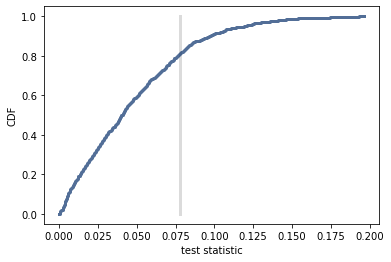

In [8]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

Under the null hypothesis, we often see differences bigger than the observed difference.

In [9]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [10]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.09

But in this example, the result is still not statistically significant.

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [11]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [12]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.077

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [13]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

Here's an example testing the correlation between birth weight and mother's age.

In [14]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

In [15]:
ht.actual, ht.MaxTestStat()

(0.06883397035410907, 0.031144263078462166)

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

In [16]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

Here's an example using the data from the book:

In [17]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.1325

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

In [18]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

Using this test, we get a smaller p-value:

In [19]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.0441

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

## Chi-square test of pregnancy length

In [20]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [21]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 28.202929587355897


## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [22]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [23]:
neg_rate = FalseNegRate(data)
neg_rate

0.73

In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [24]:
# Defining functions
def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [31]:
# selecting random sample rows from thinkstat2 ann executing Run tests to look through 

n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

9148	0.18	0.00	0.00	0.00
4574	0.51	0.01	0.00	0.00
2287	0.68	0.00	0.00	0.00
1143	0.80	0.02	0.15	0.00
571	0.42	0.04	0.00	0.07
285	0.73	0.02	0.12	0.87
142	0.34	0.35	0.49	0.18


In [32]:
# Solution goes here
# Solution

# My results:

# test1: difference in mean pregnancy length
# test2: difference in mean birth weight
# test3: correlation of mother's age and birth weight
# test4: chi-square test of pregnancy length

# n       test1   test2   test2   test4
# 9148	0.18	0.00	0.00	0.00
# 4574	0.51	0.01	0.00	0.00
# 2287	0.68	0.00	0.00	0.00
# 1143	0.80	0.02	0.15	0.00
# 571	0.42	0.04	0.00	0.07
# 285	0.73	0.02	0.12	0.87
# 142	0.34	0.35	0.49	0.18

# Conclusion: As expected, tests that are positive with large sample
# sizes become negative as we take away data.  But the pattern is
# erratic, with some positive tests even at small sample sizes.

**Exercise Page 128: 10-1 :** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [53]:
# Read the BRFSS data and extract heights and log weights.
import brfss

import random

import thinkstats2
import thinkplot

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [54]:
# Estimate intercept and slope.
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918145, 0.0052814541694177946)

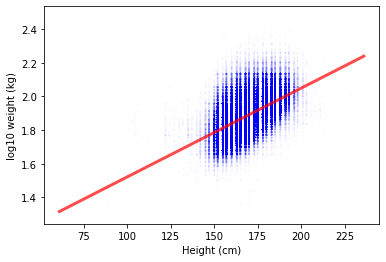

In [55]:
# Make a scatter plot of the data and show the fitted line.
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

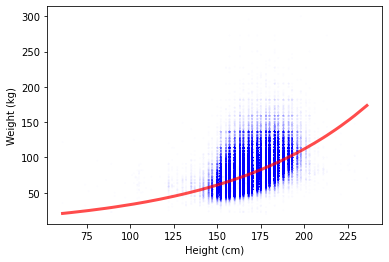

In [56]:
# Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

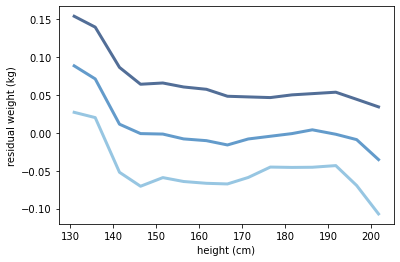

In [57]:
#Plot percentiles of the residuals.
# Solution

# The lines are flat over most of the range, 
# indicating that the relationship is linear.

# The lines are mostly parallel, indicating 
# that the variance of the residuals is the 
# same over the range.

res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

In [58]:
#Compute correlation.
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983439

In [59]:
#Compute coefficient of determination.
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.282734943118939

Confirm that $R^2 = \rho^2$.

In [60]:
rho**2 - r2

1.3322676295501878e-15

In [61]:
#Compute Std(ys), which is the RMSE of predictions that don't use height.
std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004888

In [62]:
#Compute Std(res), the RMSE of predictions that do use height.
std_res = thinkstats2.Std(res)
std_res

0.0874077708041609

In [63]:
#How much does height information reduce RMSE?

1 - std_res / std_ys

0.15308497658793352

In [64]:
#Use resampling to compute sampling distributions for inter and slope.
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

{'xscale': 'linear', 'yscale': 'linear'}

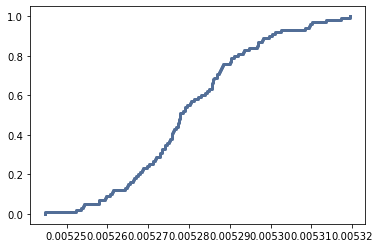

In [65]:
#Plot the sampling distribution of slope.
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [66]:
#Compute the p-value of the slope.
pvalue = cdf[0]
pvalue

0

In [67]:
#Compute the 90% confidence interval of slope.
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005254166320857264, 0.005309523901263648)

In [68]:
#Compute the mean of the sampling distribution.
mean = thinkstats2.Mean(slopes)
mean

0.005280178805505096

In [69]:
#Compute the standard deviation of the sampling distribution, which is the standard error.
stderr = thinkstats2.Std(slopes)
stderr

1.4998442682163236e-05

In [71]:
#Resample rows without weights, compute mean height, and summarize results.
from thinkstats2 import Mean, MeanVar, Var, Std, Cov
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95386095616323 0.013858238789006518 (168.93112229430668, 168.97649002607167)


In [ ]:
# Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

# The estimated mean height is almost 2 cm taller 
# if we take into account the sampling weights,
# and this difference is much bigger than the sampling error.
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)